# Notes and TODOs 

- Sometimes, we repeat the explanation of certain aspects
- The explanation of the windowing is unclear / Multiple different steps are referred to as windowing at the same time. Possibly, it will be necessary to update the Methodology figure from the paper.
- Run spell checker
- Double check figure terms to see if they allign with the text

In [1]:
%load_ext autoreload
%autoreload 2

from conscious_engie_icare.data.phm_data_handler import CACHING_FOLDER_NAME, fetch_and_unzip_data, \
                                                        load_data, BASE_PATH_HEALTHY, BASE_PATHS_TEST, PITTING_LEVELS, \
                                                        FPATH_DISTANCES
from conscious_engie_icare.nmf_profiling import extract_nmf_per_number_of_component, extract_nmf_incremental, \
                                                derive_df_vib, derive_df_orders
from conscious_engie_icare.viz.viz import illustrate_nmf_components_for_paper, illustrate_nmf_components_interactive, show_fingerprints
from conscious_engie_icare import distance_metrics
from conscious_engie_icare.normalization import normalize_1
from conscious_engie_icare.util import calculate_roc_characteristics, calc_tpr_at_fpr_threshold, calc_fpr_at_tpr_threshold
from conscious_engie_icare.preprocessing import get_and_preprocess_healthy_data, get_and_preprocess_unhealthy_data
import pickle
import os
import string
import glob
from tqdm import tqdm
from copy import deepcopy
import re
import math
import pandas as pd
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import kneed
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec

from ipywidgets import interact, Layout
import ipywidgets as widgets
from IPython.display import Markdown as md

# ignore convergence warnings (1000 iterations reached by NMF)
import warnings;
warnings.filterwarnings('ignore');

Set CACHE_RESULTS to True to cache the results of the feature extraction process. This will speed up the notebook execution time in subsequent executions.

> CODE: Robbert, do we we still need to cache results? (Maybe not, but) Robbert decides.

> Robbert, eventually the notebook needs to be colab-complaint. Check the other notebook online. Eg: https://colab.research.google.com/github/EluciDATALab/elucidatalab.starterkits/blob/main/notebooks/SK_1_2_1_Remaining_Useful_Life_Prediction/elucidata_starterkit_1_2_1.ipynb#scrollTo=1GiwjNjlhc0Y

# Starter Kit 2: Contextual Performance Profiling and Anomaly Detection

> ToDo: make clear that Anomaly Detection and Performance Profiling has their own code section.


## Business context
Industry 4.0 leverages on the advanced AI technologies to enable anomaly detection and performance profiling of industrial assets operating in different contexts. Context is defined by both internal and external factors, such as operational conditions, environmental variables, and usage patterns. For this reason, context-aware methods are fundamental to identify anomalies and to ensure accurate and reliable asset profiling. These methods allow for real-time monitoring and enable enhanced performance and reduce downtime of assets

## Business goal

The business goal related to this Starter Kit (SK) is to illustrate a data-driven methodology to identify anomalies and profile the performance of assets operating in different contexts, i.e. in terms of process measurements reflecting the internal operations of the asset.
As data-driven methodology, this SK focuses on the methodology developped by Fingerhut et al. [1, 2]. It is suitable for real-industial scenarios. [Fabian, can you complete? You can reformulate the entire sentence trying to highlight why your method is worth/convinient for real industrial scenarios] [FFNG: I added a section in the end with the reference to the two papers.]

## Application contexts

Contextual anomaly detection and performance profiling play a relevant role in a variety of industrial contexts such as: 

- Rise warning to anticipate and avoid safety-critical conditions 

- Alert inspection to avoid possible downtime and cost corrective maintenance 

- Performance benchmarking 

## Data characteristics and requirements
To showcase the SK is required a dataset that includes: 

- The vibration frequency captured by asset sensors. The captured vibration need to be related to the health state of the assets. 
- Parameters related to the internal operations of the asset.

## Starter Kit outline


> ALE: do an iteration
> 
The SK is organized in N sections:
- Background. This section provides the knowledge required to fully understand the terminology used in the rest of the document. 
- Data understanding.
  - Preprocessing. This section describes how the raw data is prepared for the analysis
  > Preprocessing should be part of section DataUnderstanding
- Methodology. This section illustrates how the methodology introduced by Fingerhut et al. [add reference] can be used for performance profiling and anomaly detection of assets/
- Conclusions



At the end of the SK you will know how to: 

- Develop a model for anomaly detection and performance profiling 

- Experimentally validate the resulting model and objectively compare it with other approaches 

- Get insights from your dataset. We will present visual and numerical techniques in order to explore your data for identifying interesting patterns [I don't think we do this. What's your opinion Robbert and Fabian? ]


## Background

> Ale: Complete
- **anomaly**: ...
- **operating mode**. An asset can operate in different contexts which can influence its behavior. We refer to these context-dependent behaviors as operating modes. As example we can imagine a waterpump which operates in two modes: normal and throttle. These two modes are
 can be isolated analzying the context, i.e. the level of warter flow. [AMUR: This example is ok, however, could you make one fitting the gearbox to be more alligned with the use case?] [FFNG: see next sentence for example with gearboxes]. As an example we can imagine a gearbox that operates in two modes: normal and throttle. These two modes can be isolated analzying the context, specifically the rotation speed of the gears. In throttle mode, the gearbox would operate under a reduced load, which would be indicated by a low rotational speed. 
- **operating and performance views**. The operating view is composed of the parameters capturing the operating context (e.g. rotation speed, torque). The performance view is composed of the parameters monitoring the performance behaviour (e.g. vibrations).

## Data understanding 

The dataset we will use in this Starter Kit come from the [PHM North America challenge '23](https://data.phmsociety.org/phm2023-conference-data-challenge/). This dataset collect the time series data from a gearbox subject to pitting, i.e. a fatigue failure of the gear tooth.
This dataset includes measurements under varied operating conditions from a healthy state as well as six known fault levels. The training data are collected from a range of different operating conditions under 15 different rotational speeds and 6 different torque levels.  For each operating condition, 5 vibration measurements were collected. 
The vibration data is given in the time domain with a sampling rate of 20480Hz. The sampling duration differs between 3 seconds and 12 seconds. For each vibration measurement there are triaxial time-domain vibration measurements available (x, y and z). Below, we visualize a vibration measurement in the three directions, as given by PHM North America. [FFNG: In its current form, it might not be entirely clear how different vibration directions are handled. --> Need to go over that.]

[[source](https://data.phmsociety.org/phm2023-conference-data-challenge/)]

<img src="https://data.phmsociety.org/wp-content/uploads/sites/9/2023/06/PHM2023dc_fig1.png" alt="MarineGEO circle logo" style="height: 375px; width:800px;"/>

A single vibration measurement (rpm=100, torque=500, run=1) has the following shape: (246785, 4)


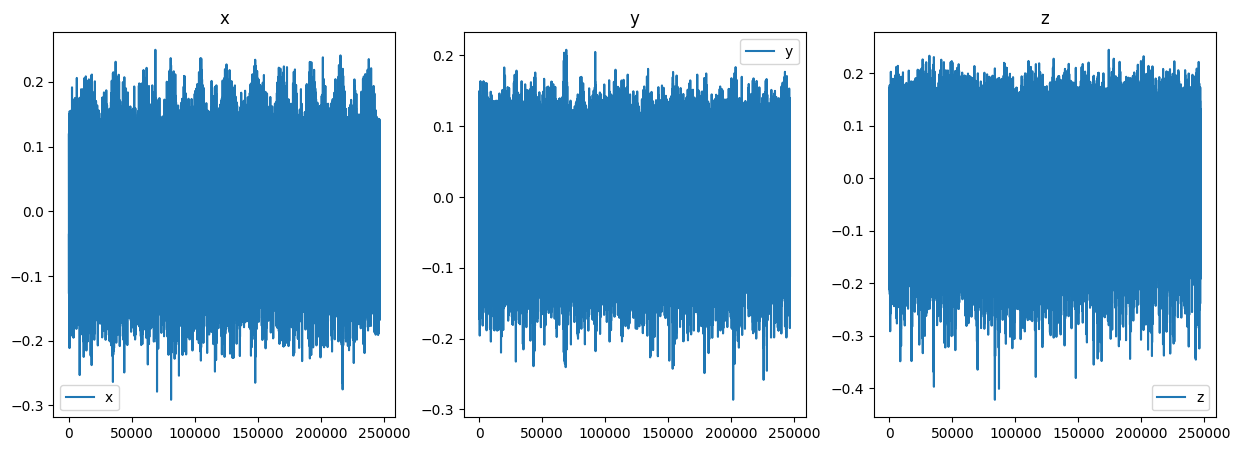

In [2]:
from conscious_engie_icare.data.phm_data_handler import load_train_data  #Robbert, Import should be put elsewhere

rpm = 100
torque = 500
run = 1
df_example = load_train_data(rpm, torque, run)
print(f"A single vibration measurement (rpm={rpm}, torque={torque}, run={run}) has the following shape: {df_example.shape}")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for var, ax in zip(['x', 'y', 'z'], axes):
    ax.plot(df_example[var], label=var)
    ax.set_title(var)
    ax.legend()

## Preprocessing

### Creation of training and testing set.

Splitting the dataset in training and testing is a common activity for validating the machine learning models. The training dataset is used to prepare a model, i.e. to train it, whereas the testing dataset is used to evaluate the performance of the model.
In our case, training and a test set are based on splitting the vibration measurements. More specifically, a random sample of 75% of the original data recorded under normal (= healthy) condition is used for training whereas the remaining 25% is used for testing.  In the rest of the document, we will only refer to this split to analyze the performance of the methodology for the sake of the computational time. On the other hand, to have more reliable results, multiple splits should be performed, i.e. multiple random samples should be extracted for the training and testing set. The interested reader can refer to Fabian et al. [2] to see the results when 100 random splits are generated.



The test set is then created by combining:
1. **Normal condition**: The 25% healthy data that was held back (not used in the training set)
2. **Anomaly condition**: Vibration data characterized by pitting level 1-8 (two more than in the training set). For each level of pitting, there are between 267 and 304 samples in the test set that were recorded at different speeds and torques. 

The figure below illustrates the train-test split.

<img src="figures/overview_train-test-split.png" alt="Overview train-test split" style="width:1000px;"/>


As next step, we preprepare the original data in the training set for the analysis.
- The **time series data** is transformed in frequency-bands. Typically, a frequency band expresses vibration behaviour in a specific range of frequencies (measured in Hertz [Hz]). We define a frequency-band in terms of "orders". Whereas a frequency measured in Hz captures the number of events per second, "orders" capture the number of events per revolution of the rotating element. Therefore, the order-transformation essentially standardizes the data. This step is important and a common preprocessing step in prognostics and health management. For details, the interested reader is referred to the vibration alignment section of Fingerhut et al. [1]. All order-transformed vibration measurements are organized in a matrix which we call **performance matrix V**.
- Meta data. The meta data contains the parameters at which the vibrations were measured:
    - The torque expresses the rotational force in terms of Newton meter.
    - The rotation speed expresses, how fast the gearbox is rotation in terms of revolutions per minute.

A brief excerpt of the **performance matrix V** is shown below.

In [3]:
# Here we need something to showcase how the training and testing dataset looks like (columns, their meaning, etc)
df_V_train, meta_data_train, df_data_healthy_test, f = get_and_preprocess_healthy_data()
df_orders_test, meta_data_test = get_and_preprocess_unhealthy_data(df_data_healthy_test, f)

# extract list of frequency band columns for later usage
cols_ = df_V_train.columns
BAND_COLS = cols_[cols_.str.contains('band')].tolist()

df_V_train.head()

,band_0.5-2.5,band_2.5-4.5,band_4.5-6.5,band_6.5-8.5,band_8.5-10.5,band_10.5-12.5,band_12.5-14.5,band_14.5-16.5,band_16.5-18.5,band_18.5-20.5,...,band_80.5-82.5,band_82.5-84.5,band_84.5-86.5,band_86.5-88.5,band_88.5-90.5,band_90.5-92.5,band_92.5-94.5,band_94.5-96.5,band_96.5-98.5,band_98.5-100.5
index,,,,,,,,,,,,,,,,,,,,,
0,0.000083,0.001135,0.000332,0.000749,0.001604,0.001779,0.002436,0.000905,0.003705,0.000203,...,0.002588,0.004577,0.005826,0.001566,0.003492,0.019335,0.006759,0.009075,0.004589,0.005449
1,0.000030,0.000419,0.000701,0.000212,0.000586,0.000226,0.000414,0.000210,0.000723,0.000209,...,0.003337,0.007597,0.015687,0.003851,0.010378,0.018125,0.005149,0.002389,0.001015,0.001774
2,0.000092,0.000264,0.000134,0.000106,0.001203,0.000446,0.018651,0.012879,0.029916,0.006926,...,0.010886,0.011106,0.026134,0.009216,0.017948,0.095809,0.018065,0.016754,0.004955,0.003817
3,0.001093,0.000285,0.000084,0.000135,0.000072,0.000105,0.000596,0.002880,0.000250,0.000562,...,0.039877,0.013978,0.009773,0.006686,0.010765,0.014013,0.009631,0.006961,0.002484,0.007278
4,0.001949,0.000557,0.000211,0.000272,0.000150,0.000162,0.000396,0.009223,0.000645,0.002202,...,0.016658,0.007494,0.015543,0.010917,0.013567,0.012068,0.006568,0.004345,0.002025,0.003673


The matrix above has n columns which represent vibration measurements and m rows which represent the frequency bins. 

Next, we illustrate the corresponding meta data, consisting of the previously described process parameters `rotational speed [RPM]` and `torque [Nm]`, and some additional information regarding the vibration measurement direction (`direction`) and sample ids (`sample_id` and `unique_sample_id`). Each row corresponds to the same row in the performance matrix. For instance, the very first measurement contains vibrations recorded at 100 RPM and 300 NM, for the vibration measurement direction x.

> Fabian, inform the reader of how many modes exists

In [4]:
meta_data_train.head()

,rotational speed [RPM],torque [Nm],direction,sample_id,unique_sample_id
0,3000,50,psd_x,4,3000_50_4
1,3000,50,psd_y,4,3000_50_4
2,3000,50,psd_z,4,3000_50_4
3,400,100,psd_x,2,400_100_2
4,400,100,psd_y,2,400_100_2


## Methodology

The methodology can be divided in the offline and online phases. The offline phase focuses on performance profiling. More specifically, the operating modes of healthy assets are extracted and mapped to the expected performances. The online phase focuses on anomaly detection by exploiting the performance profiles extracted in the previous phase.


### Offline phase

The general workflow of the offline phase is reported in the figure below.



> ToDo: Quality Check: At the end, verify that terms and symbols in this figure can be mapped with the figure. If not, either change the figure, either extend the text
<img src="figures/overview_offline-phase.png" alt="Overview offline phase" style="width:800px;"/>

> ToDo: to improve the understandability of the online part we described before hand the main steps.  -> To improve the layout, this short summary of steps should also be presented in the offline phase. Eventually, each step should be report (paying attention to right indentation). The text that follows will be then pushed to the right subsub section


This phase can be divided in N steps (See Figure above). The main goals of these phases can be summarized as follow:
1. Extraction of performance fingerprints. For each context, based gearbox speed and torque, the expected performance behavior in extracted.
2. Extraction operating modes. To each time stamp is associated an operating mode based on the context
> Fabian, did you notice that in the offline phase you first extract the performance fingerprints and then the operating mode whereas in the online phase do invert these two steps. Ideally, we should have had the same order. Is this possible that for SCANIA you keep the same order offline and online?

3. Link operating modes to performance fingerprint. To each operating mode is associated a performance fingerprint.
> Fabian, how come that for the offline phase, you need a step to connect OM to performance fingerprint. Whereas in the online phase this link is (AFAIK) embedded in the derivation of the performance fingerprint.



#### Extraction of performance fingerprints

In this step, we extract for each asset its characteristic **performance fingerprints**, i.e. its expected performance behavior in a specific context. Fingerprints are extracted by applying to the performance matrix V a _non-negative matrix factorization_ (NMF) [Fabian can you a reference to a paper (in the bottom) which explain the NMF?]. The NMF method approximates a given matrix with two lower-dimensional matrices. The approximation contains the essential information about the asset's performance. Hence, NMF reveals underlying patterns in the performance data by representing it in a simpler form. 

> From the performance matrix, it is possible to highlight similarities across asset performance. 

We apply NMF to decompose the matrix V into a separate weight matrix $\mathbf{W}$ and a component matrix $\mathbf{H}$, i.e., $\mathbf{V} \approx \mathbf{W} \times \mathbf{H}$.
Compared to other decomposition methods, NMF has the advantage that due to the entirely positive values, $\mathbf{H}$ is interpretable.

The component matrix $\mathbf{H}$ contains a set of $h$ representative components allowing to express performance behaviour in a standardized way and thus compare performance across operating modes and across assets. The matrix $\mathbf{W}$ contains the weights for reconstructing the original performance matrix $\mathbf{V}$. Each element in $\mathbf{W}$ can be interpreted as the weights of the building blocks in $\mathbf{H}$ needed to reconstruct a vibration signal encoded in the performance matrix $\mathbf{V}$. 

To decide the value $h$ of component we decompose the matrix into up to 40 components [Fabian, how did you decide to stop at 40? Based on which figure/analysis? --> **FFNG**: Time constraints. We could in theory go up to 50 = number of columns in performance matrix.][AMUR: I don't get it. Would you like to introduce an explicatory sentece on this time constraints?][**RVEB**: the MAX_N_COMPONENTS (40) sets the maximum number of components that will be extracted. This basically does 40 different decompositions (they are not entirely independent, but you can't derive one from another, unlike PCA). In the next step, the ideal number of components is selected based on the knee point/explained variance]. In the next code section, we apply the NMF to up to 40 components.

In [5]:
MAX_N_COMPONENTS = 40    # maximum number of components used to recompute

df_nmf_models = extract_nmf_incremental(df_V_train, max_n_components=MAX_N_COMPONENTS, timestamps=df_V_train.index, verbose=True)

Fitting NMF with varying number of components: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.28it/s]


> Robbert, can you further expand the section below. Point out what the reader can dinamically observe/play with. The comment below are left as starting point.
>
> **RVEB**: Will do

Below, we illustrate the decomposition of the vibration data.

The identification of the number of components to the describe the operating context is not trivial. To facilitate this process, in the plot below we provide the following plots.
- The top two plots visualize how well the performance matrix $\mathbf{V}$ can be approximated
- The left-top plot illustrates the cumulative explained variance of a principal component analysis (PCA) of the performance matrix $\mathbf{V}$. It serves as an indication of an upper bound for how well the signal could be expressed using PCA.
    - The top-righ plot illustrates the reconstruction error of the performance matrix $\mathbf{V}$ using the NMF components. The reconstruction error is calculated as the Frobenius norm of the difference between the original matrix and the reconstructed matrix. The number of components is determined by how many components in parallel running [Fabian, what is a parallel running?] [**FFNG**: PCA and NMF.][AMUR: I still don't get the sentence, can you refactor?]. PCA are needed to explain 95% of the variance in the data, corresponding to 5 components in this case.
 
Besides the visual aid, the reader can rely on the automatically extracted _knee point_ to define the number of components. The identification of this knee point is extension of the methodology presented in [2] for hyperparameter tuning for operative context detection
> [AMUR: The text below is an attempt to provide evidence that we work on T1.2 for hyperparameter tuning. Of course the text quality can be improved].


- The last 5 bottom plots illustrates the NMF components are plot.
-
> AMUR: Fabian, I don't understand what comes in the next sentence. Can you explain/rework it? Once Robbert finishes this text section, can you explain in a intuitive manner what the plots (number of components) mean? [**FFNG**: Changed it already a bit, will iterate again once Robbert is finished.]

Each of the $h$ components from $\mathbf{H}$ is illustrated in a separate lineplot. The components serve as building block of the observed vibration signals, revealing common patterns in the vibration measurements. 

For the suggested settings, it can be observed that components 1 and 2 form the basis vectors for peaks that are observed at 40 and 80 orders. These peaks are expected, as the driving gear has 40 teeth. It is common to see peaks for multiples of the number of teeth, hence there is also a peak at 80 orders. Components 3, 4 and 5 encode smaller peaks. These peaks model the noise floor.

The reader is invited to experiment multiple parameters below to verify how they affect the number of components extracted. The domain expert can use this code section to incorporate his or her domain knowledge to make more data-efficient the extraction and representation of implicit contexts. This interactivity allows to reader to beyond the XXX/[set up chosen] in the original methodology [1,2], and
[explore further]/[get more insights] on the data [Fabian can you help to complete this sentence?]



In [6]:
saved_values = illustrate_nmf_components_interactive(df_V_train, df_nmf_models)

interactive(children=(Dropdown(description='How to select the number of components for NMF', layout=Layout(wid…

We proceed with the number of components determined in the interactive figure above.



> MEMO [IGNORE this cell - this is just for AMUR to verify at the end that we actully satisfied the KPI]

We promised streamlining techniques for hyperparameter tuning and operative context detection (which are eventually connected with 1.2 and 1.3.

> We need a link with T1.2
>> T 1.2 Automated input data optimization. We will investigate methods to optimize data input in terms of
>>> dimensioning: We will investigate methods to automatically identify the time window size (what Fabian calls: windowing) used to identify operative contexts and views. 
>>> feature selection/Reduction.:We will investigate methods for automatic feature selection which allow the model to preserve its performance. 

> We need a link with T1.3
>> T.13 Context segmentation. We will investigate methods to make learning more data-efficient by incorporating domain knowledge [e.g. the end user provides constraints which can be exploited


> T3.1 (not promised but to keep in mind). Interactive visual data exploration. We will explore user-centered visualization design methodologies which can facilitate the incorporation of expert and domain knowledge. [Possible idea, we mount of top of Fabian’s method ManasaPierre’s method in order to group clusters describing operative modes -> Maybe this drift away from automatization] [This is the section of the SK where end user plays with the available features to create the view]

> AMUR: I've to make explict that the automatization is present to fullfill one of the COMPACT KPI.

> AMUR: User can introduce domain-knowledge to limit the number of component in the plot above.

In [7]:
N_COMPONENTS = saved_values['n_components']
COMPONENT_COLUMNS = list(range(N_COMPONENTS))  # used later
model = df_nmf_models[(df_nmf_models.n_components == N_COMPONENTS)].iloc[0]
display(md(f'We are using {N_COMPONENTS} component'))

We are using 5 component

> At the end of this section, the reader played with the number of components. Did we test multiple options? Should we not put a limit to avoid that the notebook breaks?

> Anyway, at this point we need to indicate that the comments which follow are based on 5 components. This is now not explicit

#### Extraction operating modes.

In this step, we extract the operating modes of the assets. In the use case, a finite number of speed and torque values are tested. We treat each unique combination of speed and torque as a separate operating mode.
We denote a operating mode as `@ X rpm, Y Nm`, where `X` corresponds to the rotational speed and `Y` corresponds to the torque. All measurements with the same rotational speed and torque are summarized in the same operating mode. There are as many operating modes, as there are unique combinations of `X` and `Y`.


> Here we could have a code block which takes the df and extract the operating modes.  
> Then we should present an excerpt of the outcome of the df. This is helpful to show the reader before hand how many OM there are and which are their names.
> 
> Other option is that we don't present the OM alone but only with the fingerprint (as it is done just in the next block)  
> CODE: Fabian we need to discuss this item since I believe this influence whether or not we keep part of the intermezzo

 


> Fabian, as far as Fig 1 reports, extraction of operating modes is a atomic and not mixed with a linking to the performance profile. Do you think you can keep them separate? Or do you think they can just be blended? I am asking because from the paper seem clearly separated.


In the table/figure above it is possible to see ... 

#### Link operating modes to performance fingerprint

In this step, we link the performance fingerprints with the operating modes. This allows to derive **context-sensitive performance fingerprints**. As each vibration measurement is assigned a operating mode, it is possible to derive fingerprints by aggregating all rows in $\mathbf{W}$ annotated with the same operating mode. 
In the following, the reader can extract and visualize for each one of the 76 operating modes the associated performance fingerprint.

> The vibration fingerprint serves as key component of the context-sensitive anomaly detection.

> CODE: Robbert a I need a code section which eventually show for one OM the performance profile. Currently, there are three code sections but I can't tell whether we need all of them for just one table. One possibility (dynamic part) is that Robbert allows the user to decide which mode he wants to display.
>
> **RVEB**: Done. Could still use more improvement in the text. Now, it assumes that all combinations of RPM and torque are present (I haven't checked). For some RPM/torque combinations, not all runs have measurements (e.g. RPM=100, torque=50, has no run=2). These are filtered out. Something similar could be done if for a given RPM value, not all torque values are present


In [8]:
show_fingerprints(model, df_V_train, meta_data_train)

interactive(children=(Dropdown(description='Which RPM', layout=Layout(width='60%'), options=((100, 100), (200,…

> **RVEB**: the text now needs adjusting. There is no labeling of OM, so talking about "OM 50" does not make sense.
>
> For reference, the OMs in the text correspond to rpm=100/torque=50 (OM 0), rpm=100/torque=100 (OM 1), and rpm=900/torque=300 (OM 50)

From the analysis of the operating modes, it is possible to observe that they present distinct performance fingerprints, as can be observed for instance when comparing operating mode (OM) 0 with OM 50. Whereas operating mode 0 predominantly expresses vibrations in the third component related to the noise floor for all vibration directions, operating mode 50 predominantly expresses vibrations in the first two components related to 40 and 80 orders. At the same time, operating modes with similar operating conditions show similar vibration fingerprints. For instance, OM 0 and OM 1 only differ slightly in the torque, which results (as expected) in similar vibration fingerprints.

> At the end of this offline phase, each operating mode has is own performance profile

### Online phase 

The general workflow of the online phase is reported in the figure below.

[**FFNG**: Depending on the text, I would need to adapt the figure after some iterations.]

<img src="figures/overview_online-phase.png" alt="Overview online phase" style="width:800px;"/>

> Part of the text below should be simplified [I need a lot of help from Fabian for this job].

This phase can be divided in five steps (See Figure above). The main goals of these phases can be summarized as follow:

4. **Windowing for incoming streaming data**. The steaming data is essentially divided in batches. This activity is generally performed to avoid the execution of the methodology for each new received data point. In this use case, windowing is not required, as the data is not coming in as a stream. For this reason, this step is skipped.
  
> Fabian, I don't see the reason of the next sentence.  Windowing is about creating batches. What's the poinnt of discussing preprocessing at this stage? This is something which could be reported elsewhere. Not here. In the next iteration I'll remove the sentence. Furthermore, we don't do windowing (as far as I can tell from the text above). So, I propose to erase the next sentences.   
> Note, that the vibration signal is subject to the same preprocessing as during the offline phase. Specifically, the vibration signal is converted from the time into the frequency domain, and then converted to orders, as described by the vibration alignment section in [1]. [Fabian, can you complete the sentence?]

7. **Detecting of the operating context**. To each time stamp is associated an operating mode among the ones identified in the offline phase.  [AMUR: Fabian, I remove 'current' from the step title. I hope this ok for you too]

8. **Deriving the performance fingerprint**. To each operating mode is associated a performance fingerprint.

7. **Estimating the fingerprint offset**. For each vibration measurement is computed the _offset_ between the fingerprints extracted online and fingerprints extracted offline. The offset quantifies to what extent the two fingerprints differs. 


8. **Deriving alarms**. In the original paper [2], based on the offset, an anomaly score is computed for each time stamp. The evolution of this score is then monitored over time to decide when to raise the alarm. In this use case, the monitoring of the anomaly score is not possible since the timestamps in the testset are not ordered. For this reason, this step is skipped.


#### Detecting of the operating context and deriving the performance fingerprint.

Detection of the operating contexts and extraction of their performance fingerpring are two straighforward operations.  
As in the offline phase, we extract the operaing modes from each time stamp present the testing dataset. The operating modes are defined up-front by the combination of rotational speed X and torque Y. Consequently, the testing set cannot have different combination from the one already present in the training set [AMUR: this should make explicit before when we explain the dataset].

As next step, we extract the performance fingerprint of each operating mode.

> To do: fix the output from the cell.
> 
> Robbert, the amount of lines connected to computional percentage is too high. Can we get rid of them and just keep the tables?
> Robbert, can you remove from the outputL Extracting and order-transforming test data. This is something that shouldn't have appened at this stage. So, better to omit from text.
> 
> Robbert, check if the preprocessing can be done all in one place (in section preprocessing)
>
> This was moved to the beginning of the notebook. Text needs to be adjusted. Do we show the table here?

In [9]:

# print('All samples from the test set are processed for all folds. Below, we show an excerpt of the first fold.')
# print('(1) `df_orders_test_folds` contains the preprocessed and order-transformed vibration bands:')
# display(df_orders_test.head())
# print('(2) `meta_data_test_folds` contains the process data (rpm, torque) and some additional information (measurement direction):')
# display(meta_data_test.head())

> Fabian, the text that follow is too abstact from the reader (or even misplaced). Could you refactor and explain in a more general manner what you want to achieve? 

For this reason, we compute ... the weights $\mathbf{W}$ from the testing data [Why we do this?]. Then, the component matrix $\mathbf{H}$ which encode the typical observed patterns from the vibration signal is taken from the offline phase. This way, the weights approximated during the online phase can be compared to the fingerprints extracted from the offline phase. [To append later before the right code section] 

> The data [which data?] is binned as during the offline phase for estimating the performance fingerprints from the validation data

> Each individual direction measurement is used as basis for the decomposition vector y1.

> CODE TO DO: move part of this code to source files

In [10]:
# extract df_W_offline and df_W_online
def extract_vibration_weights_per_measurement_period(measurement_periods, col_names, band_cols, normalization, model, verbose=False):
    Ws = []
    for period in tqdm(measurement_periods, disable=not verbose, desc='Extracting vibration weights per measurement period'):
        assert len(period) == 3, 'should have exactly 3 directions per measurement period'
        band_column_names = period.columns[period.columns.str.contains('band_')]
        V = period.set_index(['direction'])[band_column_names]  # already normalized
        W = model.nmf.transform(V.to_numpy())
        W = pd.DataFrame(W, columns=col_names)
        Ws.append({
            'unique_sample_id': period.unique_sample_id.unique()[0],
            'V_normalized': V,
            'W': W
        })
    return pd.DataFrame(Ws)

# extract train vibration measurement periods

df_V_train[['unique_sample_id', 'direction']] = meta_data_train[['unique_sample_id', 'direction']]
train_vibration_measurement_periods = []
for sample_id, group in df_V_train.groupby('unique_sample_id'):
    measurement_period = {
        'start': 'unknown', 
        'stop': 'unknown',
        'group': group,
        'sample_id': sample_id,
    }
    train_vibration_measurement_periods.append(group)

# extract test vibration measurement periods

W_train = model.W.reshape(-1, N_COMPONENTS)
df_W_train = pd.DataFrame(W_train)
#display(f'Fold {i}. Shape: {W_train_.shape}')
df_W_train.index = df_V_train.index
df_W_train['direction'] = meta_data_train['direction']

# add operating mode (OM)
df_W_train_with_OM = pd.merge(df_W_train, meta_data_train.drop(columns=['direction']), left_index=True, right_index=True)
df_W_train_with_OM['cluster_label_unique'] = df_W_train_with_OM.groupby(['rotational speed [RPM]', 'torque [Nm]']).ngroup()
cluster_label_unique_name_mapping = df_W_train_with_OM.groupby('cluster_label_unique').first()[['rotational speed [RPM]', 'torque [Nm]']].reset_index()



df_V_test_normalized = normalize_1(df_orders_test, BAND_COLS)
df_ = df_V_test_normalized
df_[['sample_id', 'unique_sample_id', 'direction']] = meta_data_test[['sample_id', 'unique_sample_id', 'direction']]
test_vibration_measurement_periods = []
test_vibration_measurement_periods_meta_data = []
n_index_errors = 0
for unique_sample_id, group in df_.groupby('unique_sample_id'):
    rpm = meta_data_test[meta_data_test['unique_sample_id'] == unique_sample_id]['rotational speed [RPM]'].unique()[0]
    torque = meta_data_test[meta_data_test['unique_sample_id'] == unique_sample_id]['torque [Nm]'].unique()[0]
    try:
        om = cluster_label_unique_name_mapping[
            (cluster_label_unique_name_mapping['rotational speed [RPM]'] == rpm) & 
            (cluster_label_unique_name_mapping['torque [Nm]'] == torque)]['cluster_label_unique'].iloc[0]
    except IndexError:
        n_index_errors += 1
        om = -1
    measurement_period = {'start': 'unknown', 
                          'stop': 'unknown',
                          'group': group,
                          'unique_sample_id': unique_sample_id,
                          'rpm': rpm,
                          'torque': torque,
                          'unique_cluster_label': om}
    test_vibration_measurement_periods.append(group)
    test_vibration_measurement_periods_meta_data.append(measurement_period)
    
n_total = len(test_vibration_measurement_periods)

grouping_vars = ['direction', 'cluster_label_unique']
df_ = df_W_train_with_OM[COMPONENT_COLUMNS + grouping_vars].copy()
fingerprints = {
    om: om_group.groupby(['direction']).mean().drop(columns=['cluster_label_unique']) for om, om_group in df_.groupby('cluster_label_unique')
}
    
df_W_offline = extract_vibration_weights_per_measurement_period(train_vibration_measurement_periods, fingerprints[0].columns, BAND_COLS, normalize_1, model)
df_W_online = extract_vibration_weights_per_measurement_period(test_vibration_measurement_periods, fingerprints[0].columns, BAND_COLS, normalize_1, model)

df_W_online.head()

,unique_sample_id,V_normalized,W
0,1000_200_1_pitting_level_3,band_0.5-2.5 band_2.5-4.5 band_4....,0 1 2 3 ...
1,1000_200_3_healthy,band_0.5-2.5 band_2.5-4.5 band_4....,0 1 2 3 ...
2,1000_300_1_healthy,band_0.5-2.5 band_2.5-4.5 band_4....,0 1 2 3 ...
3,1000_300_3_pitting_level_2,band_0.5-2.5 band_2.5-4.5 band_4....,0 1 2 3 ...
4,1000_300_3_pitting_level_8,band_0.5-2.5 band_2.5-4.5 band_4....,0 1 2 3 ...


> Fabian, we need some comment on the output above. Is there anything worth to report?
> At least mention column meaning and that the table shows the performance fingerprint. If this column is not showing the performance fingerprint then I wonder whether it is worth to keep it (I would avoid to comment on intermediate table you need to extract the performance fingerprint)

To better understand this matrix, below is illustrated the derived weights for a single measurements [Fabian, what is a single measurement? Can you add something more to clarify?]. The format of the weights is the same as of the fingerprint shown in the previous section [wich one Fabian? the online section? ]

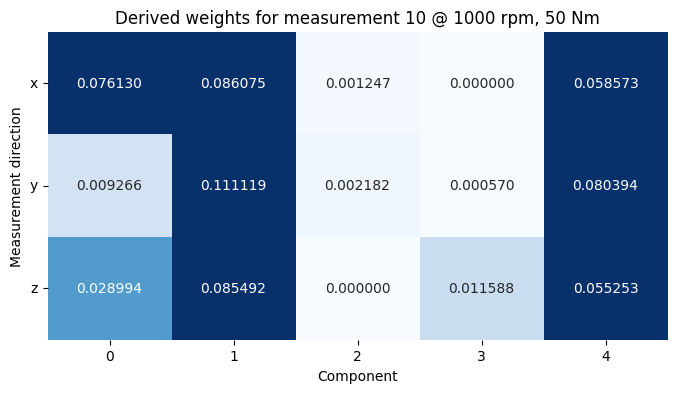

In [11]:
period = 10

usid = df_W_online['unique_sample_id'][period]
df_ = meta_data_test[meta_data_test['unique_sample_id']==usid]
rpm = df_['rotational speed [RPM]'].iloc[0]
torque = df_['torque [Nm]'].iloc[0]

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(df_W_online['W'][period], annot=True, fmt=".6f", ax=ax, cmap='Blues', vmin=0, vmax=0.05, cbar=False)
ax.set_title(f'Derived weights for measurement {period} @ {rpm} rpm, {torque} Nm');
ax.set_yticklabels(['x', 'y', 'z'], rotation=0)
ax.set_ylabel('Measurement direction')
ax.set_xlabel('Component');

> Fabian, Is there anything worth to report/comment on the table above?
> The table above shows for operating mode @ 100, 500 Nm the performance fingerprint. However, this is just the same type of table we have seen in the offline phase. Maybe we can still report something worth to mention?

> ToDo: Make clear that one aspect of the methodology (performance profiling) is reached. Next, we check the second part of the methodology: anomaly detection

#### Estimating the fingerprint offset

In order to assess
whether the performance of asset i (i = 1, . . . , n) is normal vs. anomalous, it is necessary to quantify the distance - offset - between the observed and expected fingerprints. More specifically, for each performance measurement yi, the cosine
distance between the derived weights w′i and the fingerprint fij ∈ Fi, corresponding to the detected operating mode Oij , (j = 1, . . . , ki), is used to estimate the offset:

$$ d_{cos}(\mathbf{w}_i', \mathbf{f}_{ij}) = 1 - \dfrac{\mathbf{w}_i' \cdot \mathbf{f}_{ij}}{\|\mathbf{w}_i'\| \ \|\mathbf{f}_{ij}\|} $$

where || · || is the magnitude of the corresponding vector. 

> Fabian, look at the sentence that follow. Is it worth to report?
> The derived weight vectors represent individual direction measurements as a result of decomposing per individual direction. The weight vectors are appended into a single 15-dimensional vector w′1 that is compared to the fingerprint f1j of the corresponding operating mode O1j

Once we extracted the offeset, it is possible to evaluate to what extent they can be exploited of anomaly detection. For this reason we compute, for each operating mode, the offset of the derived weights to the corresponding fingerprint below. [Fabian is this sentence correct?]

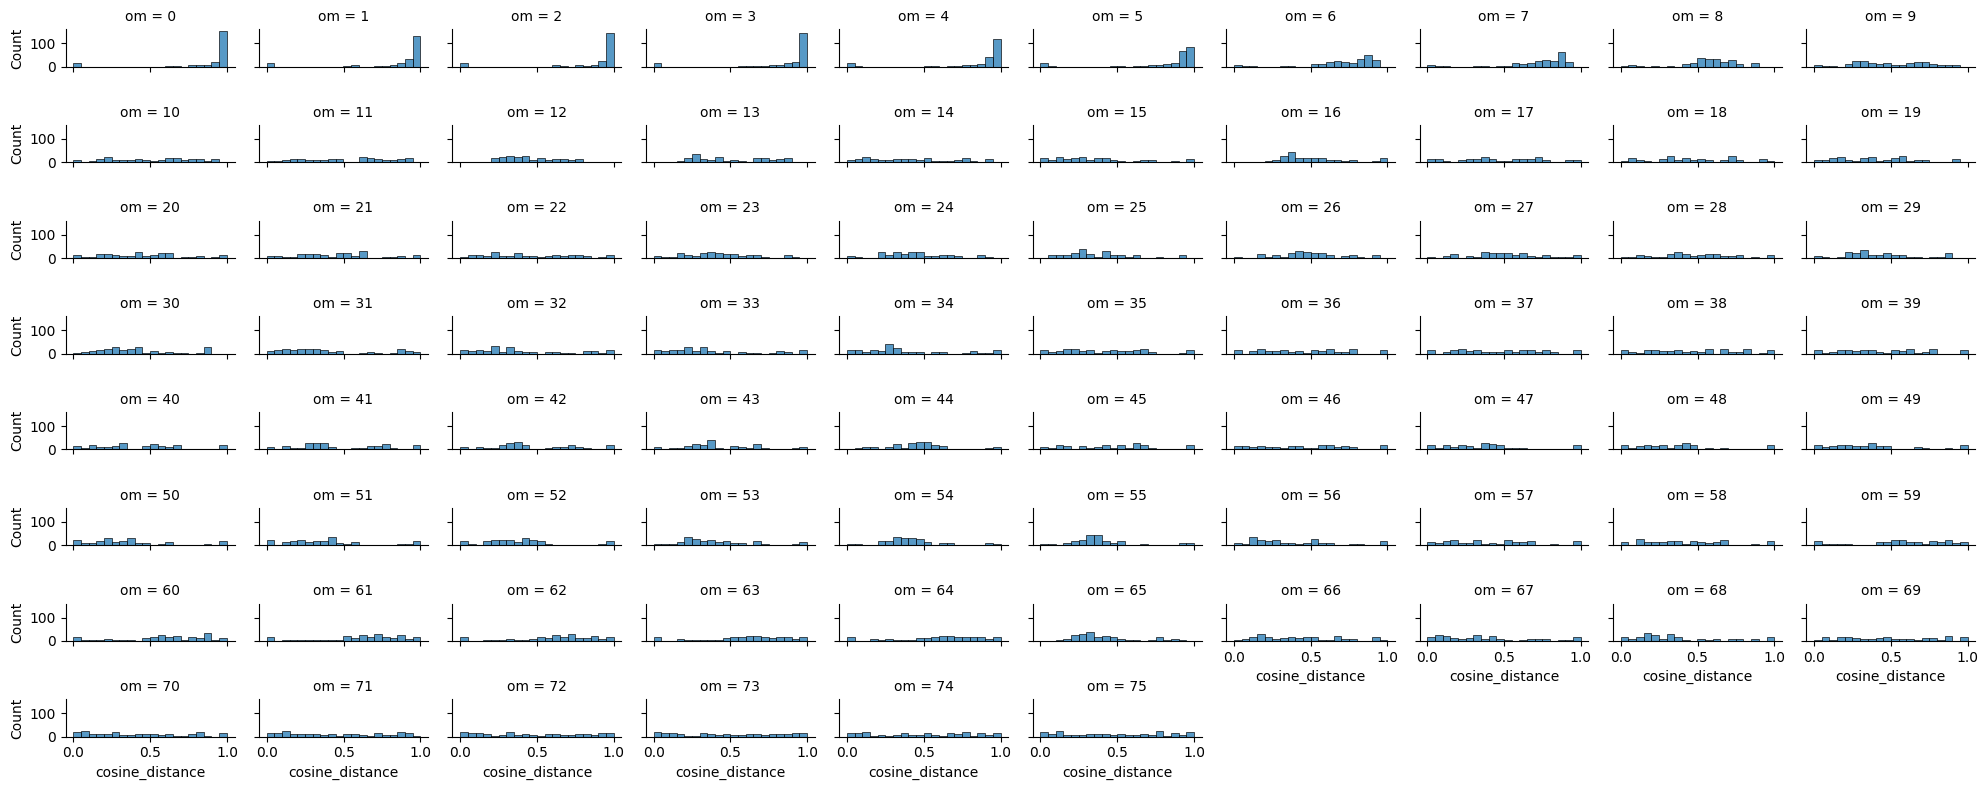

In [12]:
# cell takes around 60 minutes to run (!) --> going to cache the results
SHOW_DISTANCES = False

def calculate_distances_per_measurement_period(measurement_period, fingerprints, verbose=False):
    # pointwise Mahalanobis distance
    fingerprint_matrix = np.array([fingerprints[om].to_numpy().flatten() for om in fingerprints])
    # calculate covariance matrix
    fingerprint_S = np.cov(fingerprint_matrix.T)
    # calculate inverse
    fingerprint_SI = np.linalg.inv(fingerprint_S)
    # calculate mu
    fingerprint_mu = fingerprint_matrix.mean(axis=0)
    df_dist_ = []
    for idx, row in tqdm(measurement_period.iterrows(), total=len(measurement_period), disable=not verbose):
        for om in fingerprints:
            weights = row['W']
            fingerprint = fingerprints[om]
            tmp = {
                'idx': idx,
                'data': row, 
                'om': om, 
                #'frobenius_norm': distance_metrics.frobenius_norm(weights, fingerprint),
                #'frobenius_norm_pow2': distance_metrics.frobenius_norm_v2(weights, fingerprint),
                #'frobenius_norm_sqrt': distance_metrics.frobenius_norm_v3(weights, fingerprint),
                'cosine_distance': distance_metrics.cosine_distance(weights, fingerprint),
                'manhattan_distance': distance_metrics.manhattan_distance(weights, fingerprint),
            }
            df_dist_.append(tmp)
    df_dist_ = pd.DataFrame(df_dist_)
    return df_dist_

# calculate/load distances
fpath_offline = os.path.join(FPATH_DISTANCES, f'df_dist_offline.pkl')
os.makedirs(os.path.dirname(fpath_offline), exist_ok=True)
fpath_online = os.path.join(FPATH_DISTANCES, f'df_dist_online.pkl')
os.makedirs(os.path.dirname(fpath_online), exist_ok=True)
if os.path.exists(fpath_offline) and os.path.exists(fpath_online):
    # load cached distances
    df_dist_offline = pickle.load(open(fpath_offline, 'rb'))
    df_dist_online = pickle.load(open(fpath_online, 'rb'))
else:
    # calculate distances and cache results
    df_dist_offline = calculate_distances_per_measurement_period(df_W_offline, fingerprints=fingerprints)
    pickle.dump(df_dist_offline, open(fpath_offline, 'wb'))
    df_dist_online = calculate_distances_per_measurement_period(df_W_online, fingerprints=fingerprints)
    pickle.dump(df_dist_online, open(fpath_online, 'wb'))


# pivot cosine distance:
# for each measurement period (row), get the distance to each operating mode (column)
df_cosine = df_dist_online[['idx', 'om', 'cosine_distance']].pivot(index='idx', columns='om', values='cosine_distance')
# assign the corresponding operating mode to the given row (if known), else, assign -1
df_cosine[['rpm', 'torque', 'unique_cluster_label']] = pd.DataFrame(test_vibration_measurement_periods_meta_data)[['rpm', 'torque', 'unique_cluster_label']]

g = sns.displot(data=df_dist_offline, 
                x="cosine_distance", col="om", col_wrap=10, height=1, aspect=2, bins=20, kind="hist")

> Robbert, let the user select the mode.
> [Fabian,  report something worth to mention based on the comparison between OMs]
> The figure above is too crowded

Below, we create a pivot table of the cosine distance and compare distances between measurements and their corresponding fingerprints (left) and other fingerprints (right).

Pivot table with distances to all fingerprints (0 - 72), corresponding rpm and torque values, and additional information on the anomaly condition:


om,0,1,2,3,4,5,6,7,8,9,...,72,73,74,75,rpm,torque,unique_cluster_label,distance_to_own_cluster_center,pitting,pitting_level
idx,,,,,,,,,,,,,,,,,,,,,
0,0.950980,0.938852,0.964728,0.959624,0.950273,0.934120,0.625390,0.660814,0.489770,0.407545,...,0.541366,0.525917,0.470361,0.492032,1000,200,55,0.067243,True,3
1,0.957429,0.946591,0.970888,0.963298,0.951714,0.935288,0.639242,0.685083,0.438623,0.296894,...,0.500391,0.501929,0.478596,0.483197,1000,200,55,0.000872,False,0
2,0.976039,0.971554,0.972918,0.973461,0.968290,0.956794,0.809215,0.799196,0.660828,0.624474,...,0.102363,0.106919,0.129904,0.109789,1000,300,56,0.000605,False,0
3,0.946655,0.927782,0.958229,0.956602,0.946789,0.927670,0.585453,0.621387,0.512605,0.487824,...,0.353088,0.350476,0.337572,0.340263,1000,300,56,0.170779,True,2
4,0.962091,0.952701,0.963564,0.963490,0.952365,0.933905,0.753778,0.750903,0.561334,0.469809,...,0.205373,0.196455,0.181057,0.180890,1000,300,56,0.070838,True,8


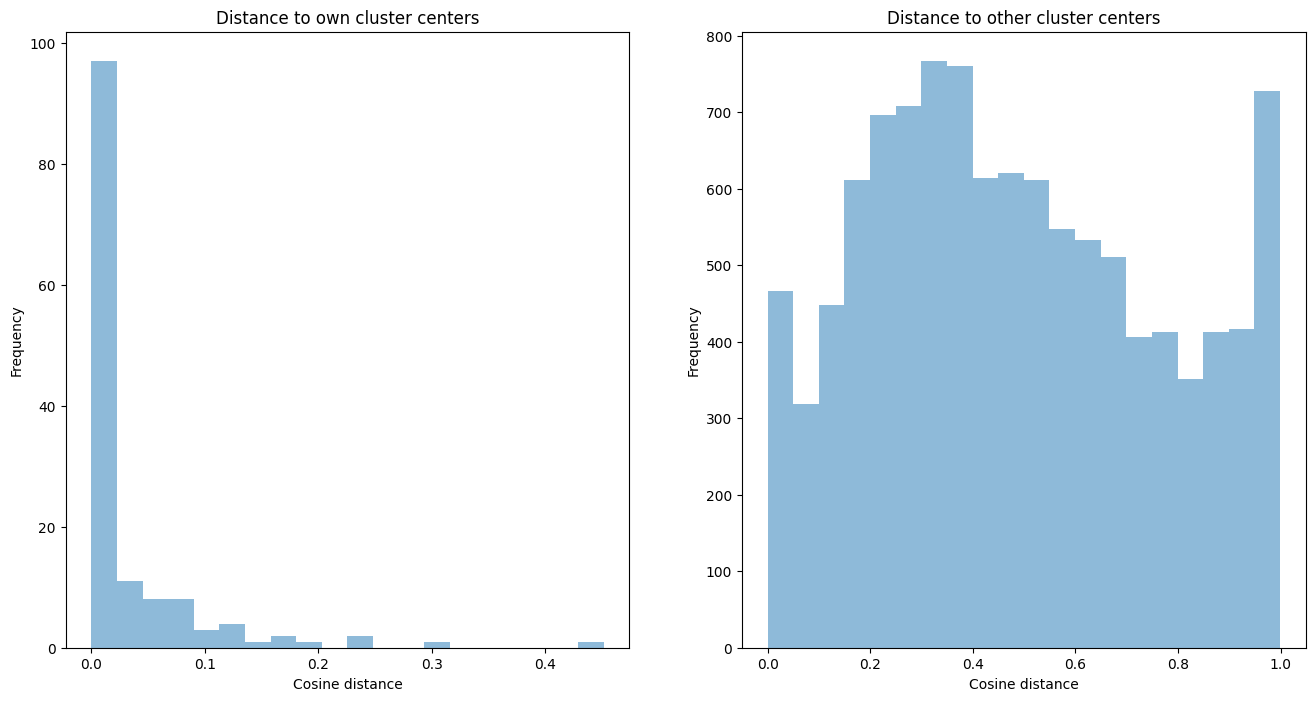

In [13]:
distance_to_own_cluster_center = []
for idx, row in df_cosine.iterrows():
    om = row['unique_cluster_label']
    if om != -1:
        distance_to_own_cluster_center.append(row[om])
    else:
        distance_to_own_cluster_center.append(np.nan)
df_cosine['distance_to_own_cluster_center'] = distance_to_own_cluster_center
df_cosine['pitting'] = df_W_online['unique_sample_id'].str.contains(f'pitting_level_')
df_cosine['pitting_level'] = df_W_online['unique_sample_id'].str.extract(r'pitting_level_(\d)')
df_cosine['pitting_level'] = df_cosine['pitting_level'].fillna(0).astype(int)

print('Pivot table with distances to all fingerprints (0 - 72), corresponding rpm and torque values, and additional information on the anomaly condition:')
display(df_cosine.head())

fig, axes = plt.subplots(figsize=(16, 8), ncols=2)

ax = df_cosine['distance_to_own_cluster_center'].plot(kind='hist', bins=20, ax=axes[0], alpha=0.5, legend=False)
ax.set_title('Distance to own cluster centers')
ax.set_xlabel('Cosine distance')

# plot distance to other cluster centers
ax = df_cosine.drop(columns=['rpm', 'torque', 'unique_cluster_label', 'distance_to_own_cluster_center', 'pitting', 'pitting_level']).melt()['value'].plot(kind='hist', bins=20, ax=axes[1], alpha=0.5, legend=False)
ax.set_title('Distance to other cluster centers')
ax.set_xlabel('Cosine distance');

> [Fabian, I think we can remove the figure above. As far as I can tell, below we just want to prove that these offset can be used for anomaly detection. Below, we have plenty of evidence]
> Fabian, If this is the case, then adapt the code. Take into account which part of the code you need.

We can now evaluate whether the performance offset can be exploited for detecting anomalies. For this reason we analyze the relation between offset distance and pitting level.

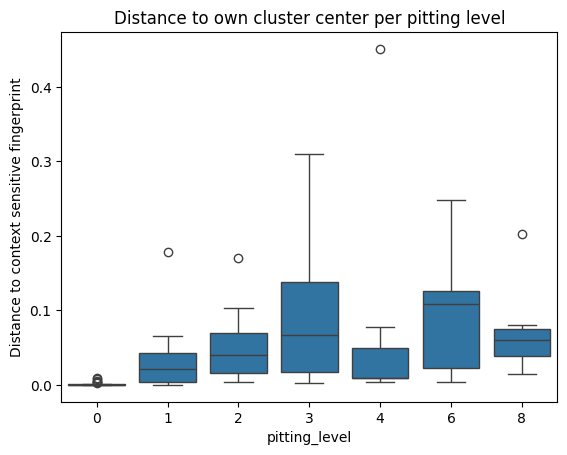

In [14]:
ax = sns.boxplot(data=df_cosine, y='distance_to_own_cluster_center', x='pitting_level')
ax.set_ylabel('Distance to context sensitive fingerprint')
ax.set_title(f'Distance to own cluster center per pitting level');

In the boxplots above it possible to observe a clear difference in terms the offset betweem healthy and faulty gearboxes, i.e. gearboxes which incurred in a pitting. This is expected, as the context-sensitive fingerprint is derived from healthy data without pitting and data with pitting is likely to have vibration patterns not present in the healthy data set.

The boxplot provides only a partial view of the ability of the methodology to identify anomalies. To fully appreciate the performance of the methodology is necessary to ... [Fabian can you continue? Maybe blend with the text that follow. What we need is the rational behind the choice of using the ROC-curve. Previously, the ROC section was just introduced without too many explanation. Here we need to introduce the rational for their usage]

Whether a datapoint is labelled as anomalous depends on a predefined distance threshold.
In this section, we caclulate ROC-curves by varying this distance threshold. [ToDo: explain what is ROC-curve. Target audience: engineer]

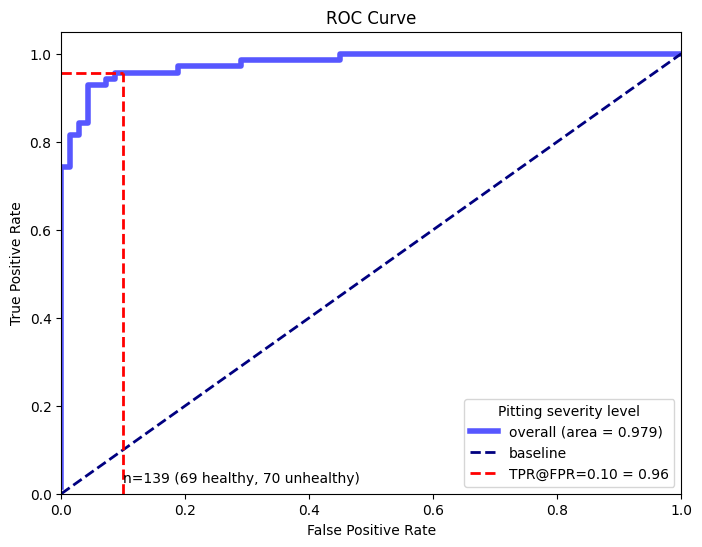

In [15]:
threshold = 0.1

df_cosine = df_cosine[df_cosine.unique_cluster_label != -1]  # removed unknown cluster labels

fig, ax = plt.subplots(figsize=(8, 6))

# Plot the general ROC curve
fpr, tpr, roc_auc = calculate_roc_characteristics(df_cosine)
tpr_at_fpr = calc_tpr_at_fpr_threshold(tpr, fpr, threshold=threshold)
ax.plot(fpr, tpr, color='blue', lw=4, label=f'overall (area = {roc_auc:.3f})', alpha=0.66)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='baseline')
ax.plot([0, threshold], [tpr_at_fpr, tpr_at_fpr], color='red', lw=2, linestyle='--', label=f'TPR@FPR={threshold:.2f} = {tpr_at_fpr:.2f}')
ax.plot([threshold, threshold], [0, tpr_at_fpr], color='red', lw=2, linestyle='--')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.05)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'ROC Curve')
n_total = len(df_cosine)
n_healthy = len(df_cosine[df_cosine['pitting'] == False])
n_unhealthy = len(df_cosine[df_cosine['pitting'] == True])
text = f"n={n_total} ({n_healthy} healthy, {n_unhealthy} unhealthy)"
ax.annotate(xy=(0.1, 0.025), text=text)

ax.legend(loc='lower right', title='Pitting severity level');

In the figure above it can be observed that the anomaly detection generally performs well with a area under the curve (AUC) of $0.962$.
Operators aim for a high true positive rate (TPR) while minimizing false alarms (keeping the false positive rate (FPR) low). We track the TPR at a stable FPR of 0.1 (TPR@FPR=0.1), which represents the TPR when there are 10% false positives. In this scenario, the TPR is 97%.

> AMUR: Fabian, I fail to see how the next plot convey usable action point for the operator.

An alternatve objective criterium is to keep the FPR as low as possible at a high TPR.
The plot below illustrates the FPR@TPR=0.1. In the shown fold, FPR@TPR=0.1 is 0.07.

> If useless, I would remove the next code snippet

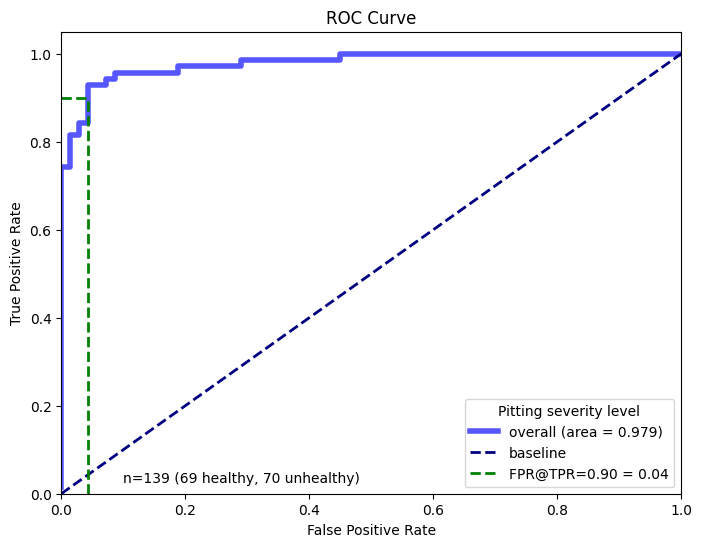

In [16]:

df_cosine = df_cosine[df_cosine.unique_cluster_label != -1]  # removed unknown cluster labels

fig, ax = plt.subplots(figsize=(8, 6))

threshold = 0.90

# Plot the general ROC curve
fpr, tpr, roc_auc = calculate_roc_characteristics(df_cosine)
fpr_at_tpr = calc_fpr_at_tpr_threshold(tpr, fpr, threshold=threshold)
ax.plot(fpr, tpr, color='blue', lw=4, label=f'overall (area = {roc_auc:.3f})', alpha=0.66)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='baseline')
ax.plot([fpr_at_tpr, fpr_at_tpr], [0, threshold], color='green', lw=2, linestyle='--', label=f'FPR@TPR={threshold:.2f} = {fpr_at_tpr:.2f}')
ax.plot([0, fpr_at_tpr], [threshold, threshold], color='green', lw=2, linestyle='--')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.05)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'ROC Curve')
n_total = len(df_cosine)
n_healthy = len(df_cosine[df_cosine['pitting'] == False])
n_unhealthy = len(df_cosine[df_cosine['pitting'] == True])
text = f"n={n_total} ({n_healthy} healthy, {n_unhealthy} unhealthy)"
ax.annotate(xy=(0.1, 0.025), text=text)

ax.legend(loc='lower right', title='Pitting severity level');

# Conclusions

In this SK we illustrate a data-driven methodology for contextual performance profiling and anomaly detection. The SK focuses on how to set up methodology parameters and correctly interpret its results. The methodology, validated on a gearbox that is subject to pitting, explain how to extract the contexts from an asset and how to use it to profile its performance. Furthermore, it proves that the performance profiles can be used to identify anomalies. For the latter, it has been show that XXX [ToDo, complete sentence citing some performance number (e.g. based on ROC)

# Additional information
The methodology presented in this notebook is based on the paper [1,2]

This Starter Kit was developed in the context of the Compact project [ToDo: Find an online reference]. For more information, please contact info@elucidata.be.

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Notebook"), to deal in the Notebook without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Notebook, and to permit persons to whom the Notebook is provided to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies of the Notebook and/or copies of substantial portions of the Notebook.

THE NOTEBOOK IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NON-INFRINGEMENT. IN NO EVENT SHALL SIRRIS, THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, DIRECT OR INDIRECT, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE NOTEBOOK OR THE USE OR OTHER DEALINGS IN THE NOTEBOOK

# References

> [Fabian can you add also an hyperlink to the paper?]

[1] F. Fingerhut, S. Klein, M. Verbeke, S. Rajendran and E. Tsiporkova, "Multi-view contextual performance profiling in rotating machinery," 2023 IEEE International Conference on Prognostics and Health Management (ICPHM), Montreal, QC, Canada, 2023, pp. 343-350, doi: 10.1109/ICPHM57936.2023.10194172.

[2] F. Fingerhut, M. Verbeke and E. Tsiporkova, "Unsupervised context-sensitive anomaly detection on streaming data relying on multi-view profiling," 2024 IEEE International Conference on Evolving and Adaptive Intelligent Systems (EAIS), Madrid, Spain, 2024, pp. 1-10, doi: 10.1109/EAIS58494.2024.10569106.

#### ©, 2024, Sirris